In [1]:
# citations of orignals:
# """
# first two attempts were DCGANs (result were mode collapse)
# MNIST DCGAN by TensorFlow Authors: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb#scrollTo=ZBwyU6t2Wf3g
# Monet_ Dataset DCGAN architecture: https://www.kaggle.com/code/thuylinh225/generate-monet-images-using-dcgan
# naming convention for models: https://github.com/thashimoto1998/DCGAN/blob/master/dcgan.py
#
# third attempt is WGAN-GP (better results)
# WGAN-GP video: https://www.youtube.com/watch?v=pG0QZ7OddX4&list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va&index=5
# WGAN-GP paper: https://arxiv.org/abs/1704.00028
# WGAN-GP github: https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/4.%20WGAN-GP
# """

In [2]:
###############################
###         Updates         ###
###############################

# added outputs folder to save GIFs

# for i in augmented_dataset:
#   i = i[0]


In [3]:
#############################
###    WGAN-GP Original    ###
#############################

In [4]:
import tensorflow as tf
import glob
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import imageio

!pip install tensorflow_docs
import tensorflow_docs.vis.embed as embed
import torchvision.transforms as tvtf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 3.2 MB/s eta 0:00:00


In [5]:
#Gather images
!git clone https://github.com/LyJacky/ImageGeneration.git

Cloning into 'ImageGeneration'...
remote: Enumerating objects: 375, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 375 (delta 27), reused 69 (delta 26), pack-reused 305
Receiving objects: 100% (375/375), 49.93 MiB | 11.18 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [6]:
# hyperparameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 32
image_size = 64
num_of_channels = 3
lambda_gradient_penalty = 10

latent_dim = 100
generator_features = 64

learning_rate = 1e-4
discriminator_features = 64
discriminator_iterations = 5

cuda


In [7]:
!rm -r /content/ImageGeneration/ImageGeneration/
!rm -r /content/ImageGeneration/.ipynb_checkpoints/
!rm -r /content/ImageGeneration/.git/

rm: cannot remove '/content/ImageGeneration/.ipynb_checkpoints/': No such file or directory


In [8]:
transforms = tvtf.Compose(
  [
    tvtf.Resize(image_size), # to 64
    tvtf.ToTensor(),
    tvtf.Normalize(
        [0.5 for _ in range(num_of_channels)], [0.5 for _ in range(num_of_channels)]
    ),
  ]
)


In [9]:
# if this error:
# FileNotFoundError: Found no valid file [...] extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp
# then: make sure to not have image_at_epoch_0010.jpg in the folder

monet_dataset = datasets.ImageFolder(root="/content/ImageGeneration/", transform=transforms)
dataloader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True)

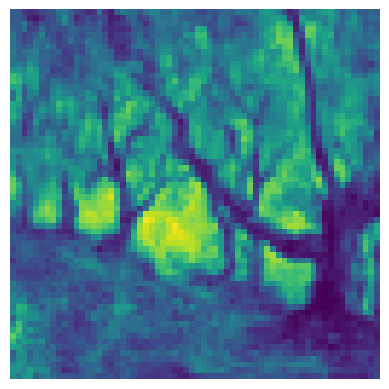

In [10]:
# show a sample
plt.imshow((monet_dataset[1][0][2]))
plt.axis('off')
plt.show()

In [11]:
def gradient_penalty(discriminator, real, fake, device="cpu"):
  batch_size, C, H, W = real.shape
  epsilon = torch.rand((batch_size, 1, 1, 1)).repeat(1, C, H, W).to(device)
  interpolated_images = real * epsilon + fake * (1 - epsilon)

  # calcuate discriminator scores
  mixed_scores = discriminator(interpolated_images)

  gradient = torch.autograd.grad(
      inputs = interpolated_images,
      outputs = mixed_scores,
      grad_outputs = torch.ones_like(mixed_scores),
      create_graph = True,
      retain_graph = True,
  )[0]

  gradient = gradient.view(gradient.shape[0], -1)
  gradient_penalty = torch.mean((gradient - 1) ** 2)
  return gradient_penalty


In [12]:
class Discriminator(nn.Module):
  def __init__(self, num_of_channels, discriminator_features):
    super(Discriminator, self).__init__()
    self.discriminator = nn.Sequential(

      # Input Layer
      nn.Conv2d(num_of_channels, discriminator_features, kernel_size = 4, stride = 2, padding = 1),
      nn.LeakyReLU(0.2),

      # Second Layer
      nn.Sequential(
        nn.Conv2d(discriminator_features, discriminator_features * 2, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.InstanceNorm2d(discriminator_features * 2, affine=True),
        nn.LeakyReLU(0.2),
      ),

      # Third Layer
      nn.Sequential(
        nn.Conv2d(discriminator_features * 2, discriminator_features * 4, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.InstanceNorm2d(discriminator_features * 4, affine=True),
        nn.LeakyReLU(0.2),
      ),

      # Fourth Layer
      nn.Sequential(
        nn.Conv2d(discriminator_features * 4, discriminator_features * 8, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.InstanceNorm2d(discriminator_features * 8, affine=True),
        nn.LeakyReLU(0.2),
      ),

      # Output Layer is 4x4 (Conv2d turns into 1x1)
      nn.Conv2d(discriminator_features * 8, 1, kernel_size=4, stride=2, padding=0)
    )


  def forward(self, x):
    return self.discriminator(x)

In [13]:
class Generator(nn.Module):
  def __init__(self, latent_dim, num_of_channels, generator_features):
    super(Generator, self).__init__()
    self.generator = nn.Sequential(

      #  Input Layer
      nn.Sequential(
        nn.ConvTranspose2d(latent_dim, generator_features * 16, kernel_size=4, stride=1, padding=0, bias=False,),
        nn.BatchNorm2d(generator_features * 16),
        nn.ReLU(),
      ),

      #  Second Layer
      nn.Sequential(
        nn.ConvTranspose2d(generator_features * 16, generator_features * 8, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.BatchNorm2d(generator_features * 8),
        nn.ReLU(),
      ),

      #  Third Layer
      nn.Sequential(
        nn.ConvTranspose2d(generator_features * 8, generator_features * 4, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.BatchNorm2d(generator_features * 4),
        nn.ReLU(),
      ),

      #  Fourth Layer
      nn.Sequential(
        nn.ConvTranspose2d(generator_features * 4, generator_features * 2, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.BatchNorm2d(generator_features * 2),
        nn.ReLU(),
      ),

      #  Output Layer
      nn.ConvTranspose2d(generator_features * 2, num_of_channels, kernel_size=4, stride=2, padding=1),
      nn.Tanh(),
  )

  def forward(self, x):
    return self.generator(x)

In [14]:
def initialize_weights(model):
  for m in model.modules():
      if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
          nn.init.normal_(m.weight.data, 0.0, 0.02)

In [15]:
def save_checkpoints(state, filename="monet_wgan_gp.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state, filename)

def load_checpoint(checkpoint, generator, disc):
  print("=> Loading checkpoint")
  generator.load_state_dict(checkpoint['generator'])   # generator
  disc.load_state_dict(checkpoint['disciminator']) # discriminator

In [16]:
def wgan_generate_images():
  noise = tf.random.normal([batch_size, latent_dim])
  fake = generator(noise)
  return fake

def wgan_generate_and_plot_images():
  image = wgan_generate_images()
  generator_imgs = 0.5 * image + 0.5
  fig = plt.figure(figsize=(10, 10))
  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(generator_imgs[i, :, :, :])
      plt.axis('off')
  plt.show()

In [17]:
generator = Generator(latent_dim, num_of_channels, generator_features).to(device)
discriminator = Discriminator(num_of_channels, discriminator_features).to(device)

initialize_weights(generator)
initialize_weights(discriminator)

opt_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.0, 0.9))
opt_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.0, 0.9))

step = 0

In [18]:
generator.train()

Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(12

In [19]:
discriminator.train()

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [20]:
EPOCHS = 5

In [21]:
!PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
!mkdir /content/outputs
!mkdir /content/outputs/first_wgan

In [22]:
noise_dim = 100
num_examples_to_generate = 5

# We will reuse this seed overtime to visualize progress in the animated GIF
seed = torch.randn(num_examples_to_generate, noise_dim, 1, 1).to(device)

EPOCH [0/5] Batch 0/10 Loss D: -23.8511, loss G: 31.3082


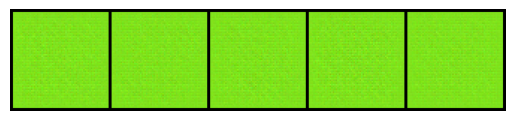

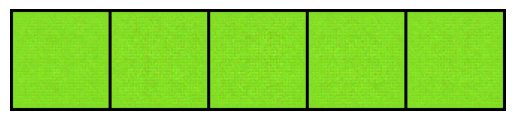

In [23]:
#training

for epoch in range(EPOCHS):
  for batch_idx, (real_img, _) in enumerate(dataloader):
    # print("batch_idx}/{len(dataloader)", batch_idx, "/", len(dataloader))
    real = real_img.to(device)
    if len(real) < 32: # sometimes had tensor of size 12
        break

    for _ in range(discriminator_iterations):
      # print("\t\tnested_for", _, "/", discriminator_iterations)
      noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
      fake = generator(noise)
      #######................................................#########
      # print("fake.shape: ", fake.shape)
      # print("fake.len: ", len(fake))
      # print("disc(fake): ", discriminator(fake))
      ####^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^######

      disc_real = discriminator(real).reshape(-1)
      disc_fake = discriminator(fake).reshape(-1)

      #########.............................................###########
      # print("real.shape: ", real.shape)
      # print("fake.shape: ", fake.shape)
      # print("disc(fake): ", discriminator(fake))
      ########^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^########

      gradient_pen = gradient_penalty(discriminator, real, fake, device=device)
      loss_discriminator = (
          -(torch.mean(disc_real) - torch.mean(disc_fake)) + lambda_gradient_penalty*gradient_pen
      )
      discriminator.zero_grad()
      loss_discriminator.backward(retain_graph=True)
      opt_discriminator.step()

    output = discriminator(fake).reshape(-1)
    loss_generator = -torch.mean(output)
    generator.zero_grad()
    loss_generator.backward()
    opt_generator.step()

    #generate pics
    with torch.no_grad():
        img_grid_fake = torchvision.utils.make_grid(
          fake[:5], normalize=True
        )
        plt.imshow(img_grid_fake.cpu().detach().numpy().transpose(1, 2, 0))
        plt.axis('off')
        if epoch % 5 == 0 and batch_idx == 0:
          print(
              f"EPOCH [{epoch}/{EPOCHS}] Batch {batch_idx}/{len(dataloader)} Loss D: {loss_discriminator:.4f}, loss G: {loss_generator:.4f}"
          )
          plt.show()

    # generate with seed and save GIF
    with torch.no_grad():
        if epoch % 2 == 0 and batch_idx == 0:
          fake = generator(seed)
          img_grid_fake = torchvision.utils.make_grid(
            fake[:5], normalize=True
          )
          plt.imshow(img_grid_fake.cpu().detach().numpy().transpose(1, 2, 0))
          plt.axis('off')
          plt.savefig('/content/outputs/first_wgan/image_at_epoch_{:04d}.png'.format(epoch + 1))

    step += 1

In [24]:
anim_file = 'wgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/outputs/first_wgan/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

<ipython-input-24-2def134f9928>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



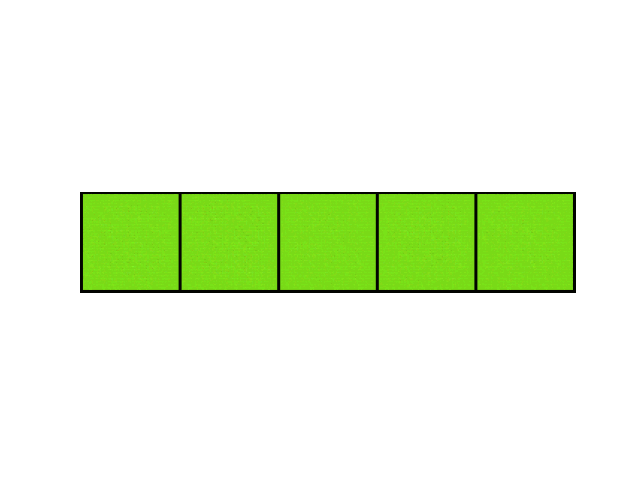

In [25]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [26]:
#############################
###    WGAN-GP Attempt    ###
#############################

In [27]:
"""
latent dim 100
# (grid output, vibrant colors) gen-layer 2048
# gen-layer 1536 -> might be my output layer

image_size = 128
layers: 4096 and 2048


original size:
  batch_idx}/{len(dataloader) 1 / 10
      nested_for 1 / 5


fivecrop size:
  batch_idx}/{len(dataloader) 1 / 113
      nested_for 1 / 3

randomcrop (3) size:
  batch_idx}/{len(dataloader) 1 / 70
      nested_for 1 / 3

randomcrop (2) size:
  batch_idx}/{len(dataloader) 1 / 57
      nested_for 1 / 3


functional.five_crop(img[0], 32)
"""

'\nlatent dim 100\n# (grid output, vibrant colors) gen-layer 2048\n# gen-layer 1536 -> might be my output layer\n\nimage_size = 128\nlayers: 4096 and 2048\n\n\noriginal size:\n  batch_idx}/{len(dataloader) 1 / 10 \n      nested_for 1 / 5\n\n\nfivecrop size:\n  batch_idx}/{len(dataloader) 1 / 113  \n      nested_for 1 / 3\n\nrandomcrop (3) size:\n  batch_idx}/{len(dataloader) 1 / 70\n      nested_for 1 / 3\n\nrandomcrop (2) size:\n  batch_idx}/{len(dataloader) 1 / 57\n      nested_for 1 / 3\n\n\nfunctional.five_crop(img[0], 32)\n'

In [28]:
""""
dataset = datasets.

change init dim?

- change cpu in gradient_penalty?
- (good) different learning rates for disc, gen
- (didnt work, cuda runs out of memory) image size = 256, discriminator_featuresISC = 256, generator_featuresEN = 256
- batch 64 (less than 64 breaks break)
- (bad, generated rotated images) rotated image gave decent results
- if RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (4 x 4). \
    - resize image to 64

Attention Mechanisms: Used to focus on specific regions of the input, improving the quality of generated samples.
Generator: Transposed Convolutional (Deconvolutional) Layers: These layers “upsample” the data, allowing the generator to create higher-resolution images.
Discri Pooling Layers: Used to downsample feature maps, reducing spatial dimensions.

- padding = 2 # used to be 1
- kernel size = 5

==============================================================================================
dataloader = DataLoader(final_dataset, batch_size=16, shuffle=True)

Gen.output(512, 3, kernel_size=4, stride=4, padding=1), [3, 126, 126]
Gen.output(256, 3, kernel_size=6, stride=2, padding=2), [3, 66, 66]
Gen.output(256, 3, kernel_size=2, stride=2, padding=1), [3, 62, 62]
Gen.output(256, 3, kernel_size=1, stride=2, padding=1), [3, 61, 61]
Gen.output(256, 3, kernel_size=4, stride=1, padding=1), [3, 33, 33]


here
Gen.output(128, 3, kernel_size=4, stride=2, padding=1), [3, 64, 64]

image_size_1 - kernel + (2*padding)
-----------------------------------+1 = 128-4+2 = 126/2 = 63+1 = 64
         stride

    k   p       s
256-4+2*1 = 254/2 = 127+1 = 128
==============================================================================================

init weights

Constrain Critic Weights:
After each mini-batch update, limit the critic model weights to a specific range (e.g., [-0.01, 0.01]).
This constraint prevents the critic from becoming too dominant and ensures stability during training.
"""

'"\ndataset = datasets.\n\nchange init dim?\n\n- change cpu in gradient_penalty?\n- (good) different learning rates for disc, gen\n- (didnt work, cuda runs out of memory) image size = 256, discriminator_featuresISC = 256, generator_featuresEN = 256\n- batch 64 (less than 64 breaks break)\n- (bad, generated rotated images) rotated image gave decent results\n- if RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (4 x 4).     - resize image to 64\n\nAttention Mechanisms: Used to focus on specific regions of the input, improving the quality of generated samples.\nGenerator: Transposed Convolutional (Deconvolutional) Layers: These layers “upsample” the data, allowing the generator to create higher-resolution images.\nDiscri Pooling Layers: Used to downsample feature maps, reducing spatial dimensions.\n\n- padding = 2 # used to be 1\n- kernel size = 5\n\n==============================================================================================\ndataloader = Da

In [29]:
import tensorflow as tf
import glob
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import imageio

!pip install tensorflow_docs
import tensorflow_docs.vis.embed as embed
import torchvision.transforms as tvtf

In [30]:
#Gather images
!git clone https://github.com/LyJacky/ImageGeneration.git

fatal: destination path 'ImageGeneration' already exists and is not an empty directory.


In [31]:
# hyperparameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 16
image_size = 128
num_of_channels = 3
lambda_gradient_penalty = 10

discriminator_learning_rate = 1e-4
discriminator_features = 128
discriminator_iterations = 3

latent_dim = 100
generator_features = 256
generator_learning_rate = 5e-5

cuda


In [32]:
!rm -r /content/ImageGeneration/ImageGeneration/
!rm -r /content/ImageGeneration/.ipynb_checkpoints/
!rm -r /content/ImageGeneration/.git/

rm: cannot remove '/content/ImageGeneration/ImageGeneration/': No such file or directory
rm: cannot remove '/content/ImageGeneration/.ipynb_checkpoints/': No such file or directory
rm: cannot remove '/content/ImageGeneration/.git/': No such file or directory


In [33]:
# if FileNotFoundError: Found no valid file [...] extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp
# then: remove other non-image files including .git hidden folder (cell above)

to_tensor_transforms = tvtf.Compose(
  [
    tvtf.Resize(image_size),
    tvtf.ToTensor(),
  ]
)

pix2tensor_dataset = datasets.ImageFolder(root="/content/ImageGeneration/", transform=to_tensor_transforms)

In [34]:
### Augment folder: five_crop
# !rm -r /content/augmented_images/monet/
# !rm -r /content/augmented_images/

# os.mkdir("/content/augmented_images")
# os.mkdir("/content/augmented_images/monet")

# to_pil_image = tvtf.ToPILImage()

# counter = 0
# for img in pix2tensor_dataset:
#   five_images_cropped_from_one = tvtf.functional.five_crop(img[0], image_size)

#   for new_img in five_images_cropped_from_one:
#     pil_image = to_pil_image(new_img)

#     pil_image.save('/content/augmented_images/monet/augmented_image_{:04d}.png'.format(counter + 1))
#     counter += 1

In [35]:
## Augment folder: random_crop
!rm -r /content/augmented_images/monet/
!rm -r /content/augmented_images/

os.mkdir("/content/augmented_images")
os.mkdir("/content/augmented_images/monet")

to_pil_image = tvtf.ToPILImage()

counter = 0

"""
cropper = v2.RandomCrop(size=(128, 128))
crops = [cropper(orig_img) for _ in range(4)]
plot([orig_img] + crops)
"""

for original_image in pix2tensor_dataset:
  cropper = tvtf.RandomCrop(size=(image_size,image_size))
  # print("original_image: ", original_image)
  # print("len.original_image: ", len(original_image))
  # print("original_image.sjape: ", original_image.shape)
  crops = [cropper(original_image[0]) for _ in range(2)]
  # print("crops.shape:", crops.shape)
  # print("len.crops:", crops)
  # print("crops:", crops)

  for new_img in crops:
    pil_image = to_pil_image(new_img)

    pil_image.save('/content/augmented_images/monet/augmented_image_{:04d}.png'.format(counter + 1))
    counter += 1

rm: cannot remove '/content/augmented_images/monet/': No such file or directory
rm: cannot remove '/content/augmented_images/': No such file or directory


In [36]:
transforms = tvtf.Compose(
  [
    tvtf.Resize(image_size), # to 64
    tvtf.ToTensor(),
    tvtf.Normalize(
        [0.5 for _ in range(num_of_channels)], [0.5 for _ in range(num_of_channels)]
    ),
  ]
)

monet_dataset = datasets.ImageFolder(root="/content/ImageGeneration/", transform=transforms)
augmented_dataset = datasets.ImageFolder(root="/content/augmented_images/", transform=transforms)

In [37]:
print("length of original monet dataset: ", len(monet_dataset))
print("length of augmented dataset (five_crop): ", len(augmented_dataset))

length of original monet dataset:  300
length of augmented dataset (five_crop):  600


In [38]:
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
counter = 1
#to change the length of the dataloader
def collate_fn(data):
    imgs, lengths = data[0][0], data[0][1]
    # print("collage_fn.len(imgs)", len(imgs))        # 3
    # print("collage_fn.(imgs.shapes)", imgs.shapes)  # 0
    # print("collage_fn.lengths", lengths)
    return torch.tensor(imgs), torch.tensor([lengths])

In [39]:
print(augmented_dataset[0][0].shape)
print("len(augmented_dataset)", len(augmented_dataset))

final_dataset = ConcatDataset([monet_dataset, augmented_dataset])

print("len(final_dataset)", len(final_dataset))
dataloader = DataLoader(final_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

torch.Size([3, 128, 128])
len(augmented_dataset) 600
len(final_dataset) 900


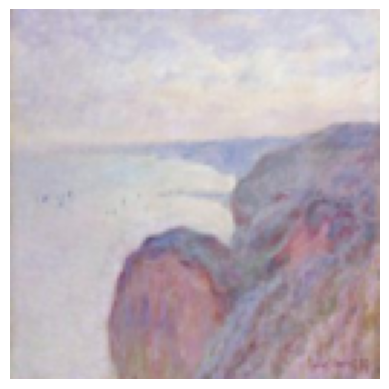

In [40]:
original_sample = to_pil_image(pix2tensor_dataset[10][0])

plt.imshow(original_sample)
plt.axis('off')
plt.show()

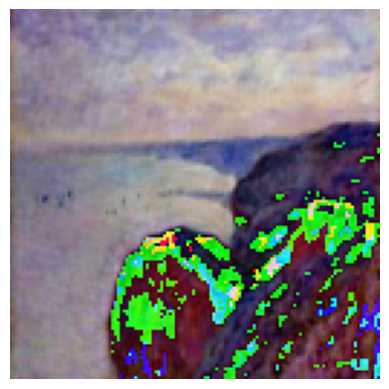

In [41]:
normalized_sample = to_pil_image(final_dataset[10][0])

plt.imshow(normalized_sample)
plt.axis('off')
plt.show()

In [42]:
def gradient_penalty(discriminator, real, fake, device="cpu"):
  BATCH_SIZE, C, H, W = real.shape
  epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
  interpolated_images = real * epsilon + fake * (1 - epsilon)

  # calcuate discriminator scores
  mixed_scores = discriminator(interpolated_images)

  gradient = torch.autograd.grad(
      inputs = interpolated_images,
      outputs = mixed_scores,
      grad_outputs = torch.ones_like(mixed_scores),
      create_graph = True,
      retain_graph = True,
  )[0]

  gradient = gradient.view(gradient.shape[0], -1)
  gradient_penalty = torch.mean((gradient - 1) ** 2)
  return gradient_penalty

In [43]:
class Discriminator(nn.Module):
  def __init__(self, num_of_channels, discriminator_features):
    super(Discriminator, self).__init__()
    self.discriminator = nn.Sequential(

      # Input Layer
      nn.Conv2d(num_of_channels, discriminator_features, kernel_size = 4, stride = 2, padding = 1),
      nn.LeakyReLU(0.2),

      # Second Layer
      nn.Sequential(
        nn.Conv2d(discriminator_features, discriminator_features * 2, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.InstanceNorm2d(discriminator_features * 2, affine=True),
        nn.LeakyReLU(0.2),
      ),

      # Third Layer
      nn.Sequential(
        nn.Conv2d(discriminator_features * 2, discriminator_features * 4, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.InstanceNorm2d(discriminator_features * 4, affine=True),
        nn.LeakyReLU(0.2),
      ),

      # Fourth Layer
      nn.Sequential(
        nn.Conv2d(discriminator_features * 4, discriminator_features * 8, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.InstanceNorm2d(discriminator_features * 8, affine=True),
        nn.LeakyReLU(0.2),
      ),

      # Fifth Layer
      nn.Sequential(
        nn.Conv2d(discriminator_features * 8, discriminator_features * 16, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.InstanceNorm2d(discriminator_features * 16, affine=True),
        nn.LeakyReLU(0.2),
      ),

      # Output Layer is 4x4 (Conv2d turns into 1x1)
      nn.Conv2d(discriminator_features * 16, 1, kernel_size=4, stride=2, padding=0)
    )


  def forward(self, x):
    return self.discriminator(x)

In [44]:
class Generator(nn.Module):
  def __init__(self, latent_dim, num_of_channels, generator_features):
    super(Generator, self).__init__()
    self.generator = nn.Sequential(

      #  Input Layer
      nn.Sequential(
        nn.ConvTranspose2d(latent_dim, generator_features * 16, kernel_size=4, stride=1, padding=0, bias=False,),
        nn.BatchNorm2d(generator_features * 16),
        nn.ReLU(),
      ),

      #  Second Layer
      nn.Sequential(
        nn.ConvTranspose2d(generator_features * 16, generator_features * 8, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.BatchNorm2d(generator_features * 8),
        nn.ReLU(),
      ),

      #  Third Layer
      nn.Sequential(
        nn.ConvTranspose2d(generator_features * 8, generator_features * 4, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.BatchNorm2d(generator_features * 4),
        nn.ReLU(),
      ),

      #  Fourth Layer
      nn.Sequential(
        nn.ConvTranspose2d(generator_features * 4, generator_features * 2, kernel_size=4, stride=2, padding=1, bias=False,),
        nn.BatchNorm2d(generator_features * 2),
        nn.ReLU(),
      ),

      #  Output Layer
      nn.ConvTranspose2d(generator_features * 2, num_of_channels, kernel_size=6, stride=4, padding=1),
      nn.Tanh(),
  )

  def forward(self, x):
    return self.generator(x)

In [45]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [46]:
def save_checkpoints(state, filename="monet_wgan_gp.pth.tar"):
  print("=> Saving checkpoint")
  os.mkdir('/content/checkpoints/')
  os.chdir('/content/checkpoints/')
  torch.save(state, filename)

def load_checpoint(checkpoint, generator, discriminator):
  print("=> Loading checkpoint")
  os.chdir('/content/checkpoints/')
  generator.load_state_dict(checkpoint['generator'])   # generator
  discriminator.load_state_dict(checkpoint['discriminator']) # discriminator

In [47]:
def wgan_generate_images():
  noise = tf.random.normal([batch_size, latent_dim])
  fake = generator(noise)
  return fake

def wgan_generate_and_plot_images():
  image = wgan_generate_images()
  generator_imgs = 0.5 * image + 0.5
  fig = plt.figure(figsize=(10, 10))
  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(generator_imgs[i, :, :, :])
      plt.axis('off')
  plt.show()

In [48]:
generator= Generator(latent_dim, num_of_channels, generator_features).to(device)
discriminator = Discriminator(num_of_channels, discriminator_features).to(device)

initialize_weights(generator)
initialize_weights(discriminator)

opt_generator= optim.Adam(generator.parameters(), lr=generator_learning_rate, betas=(0.0, 0.9))
opt_discriminator = optim.Adam(discriminator.parameters(), lr=generator_learning_rate, betas=(0.0, 0.9))

step = 0

In [49]:
generator.train()

Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 4096, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(4096, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspos

In [50]:
discriminator.train()

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(4, 4), st

In [51]:
epochs = 5

In [52]:
!PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
!mkdir /content/outputs
!mkdir /content/outputs/second_wgan

mkdir: cannot create directory ‘/content/outputs’: File exists


In [53]:
noise_dim = 100
num_examples_to_generate = 5

# We will reuse this seed overtime to visualize progress in the animated GIF
seed = torch.randn(num_examples_to_generate, noise_dim, 1, 1).to(device)

In [54]:
print(dataloader)


batch_idx: 0
real_img.shape torch.Size([3, 128, 128])
len(real_img) 3
_ tensor([0])

len(dataloader) 57


<ipython-input-38-375bc3fd4dec>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(imgs), torch.tensor([lengths])


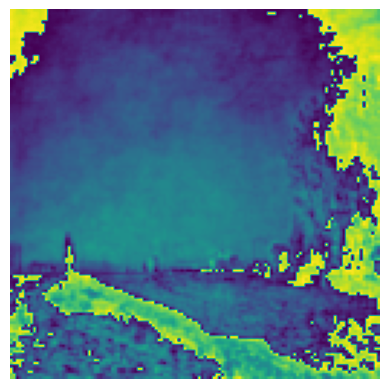


batch_idx: 1
real_img.shape torch.Size([3, 128, 128])
len(real_img) 3
_ tensor([0])

len(dataloader) 57


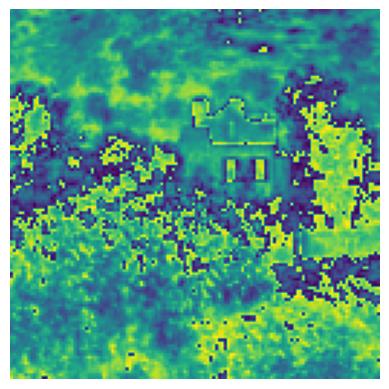

In [55]:
counter = 1
for batch_idx, (real_img, _) in enumerate(dataloader):
  if counter < 3:
    print()
    print('batch_idx:', batch_idx)
    print("real_img.shape", real_img.shape)
    print("len(real_img)", len(real_img))
    print("_", _)
    print()
    print('len(dataloader)', len(dataloader))
    counter += 1

    original_sample = to_pil_image(real_img[0])

    plt.imshow(original_sample)
    plt.axis('off')
    plt.show()


In [56]:
#training

for epoch in range(epochs):
  for batch_idx, (real_img, _) in enumerate(dataloader):
    real = real_img.to(device)
    # print("batch_idx}/{len(dataloader)", batch_idx, "/", len(dataloader))
    if len(real) < 16: # sometimes had tensor of size 12
        break

    for _ in range(discriminator_iterations):
      # print("\t\tnested_for", _, "/", discriminator_iterations)
      # print("nested_for._", _)
      noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
      fake = generator(noise)
      # #######................................................#########
      # print("fake.shape: ", fake.shape)  torch.Size([16, 3, 128, 128])
      # print("len.fake: ", len(fake))
      # print("disc(fake): ", discriminator(fake))
      # ####^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^######

      disc_real = discriminator(real).reshape(-1)
      disc_fake = discriminator(fake).reshape(-1)

      # print("real.shape: ", real.shape)
      # print("fake.shape: ", fake.shape)
      # print("disc(fake): ", discriminator(fake))

      gradient_pen = gradient_penalty(discriminator, real, fake, device=device)
      loss_discriminator = (
          -(torch.mean(disc_real) - torch.mean(disc_fake)) + lambda_gradient_penalty*gradient_pen
      )
      discriminator.zero_grad()
      loss_discriminator.backward(retain_graph=True)
      opt_discriminator.step()

    output = discriminator(fake).reshape(-1)
    loss_generator = -torch.mean(output)
    generator.zero_grad()
    loss_generator.backward()
    opt_generator.step()

    #generate pics
    # if epoch % 5 == 0 and batch_idx % 25 == 0:
    if batch_idx % 25 == 0:
      with torch.no_grad():
            img_grid_fake = torchvision.utils.make_grid(
              fake[:5], normalize=True
            )
            plt.imshow(img_grid_fake.cpu().detach().numpy().transpose(1, 2, 0))
            plt.axis('off')
            print(
                f"EPOCH [{epoch}/{epochs}] Batch {batch_idx}/{len(dataloader)} Loss D: {loss_discriminator:.4f}, loss G: {loss_generator:.4f}"
            )
            plt.show()

    # if epoch % 2 == 0 and batch_idx % 20 == 0:
    if batch_idx % 20 == 0:
      with torch.no_grad():
          fake = generator(seed)
          img_grid_fake = torchvision.utils.make_grid(
            fake[:5], normalize=True
          )
          plt.imshow(img_grid_fake.cpu().detach().numpy().transpose(1, 2, 0))
          plt.axis('off')
          plt.savefig('/content/outputs/second_wgan/image_at_epoch_{:04d}.png'.format(epoch + 1))

    step += 1

<ipython-input-38-375bc3fd4dec>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(imgs), torch.tensor([lengths])


In [57]:
anim_file = 'wgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/outputs/second_wgan/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)


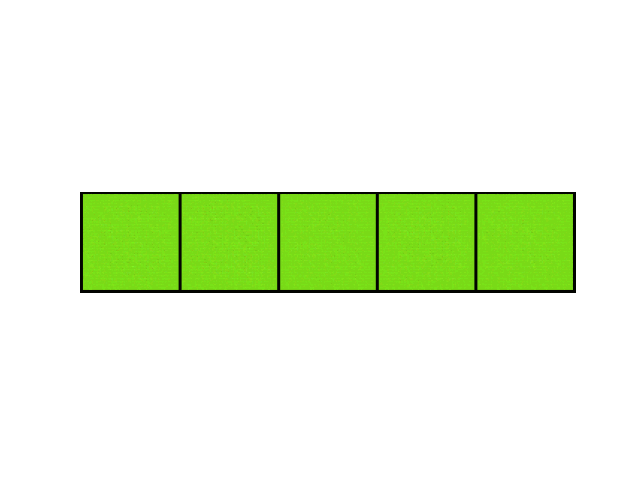

In [58]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)